## Семинар 4: "Сверточные сети"

ФИО: 

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [3]:
def t_convolve(signal, kernel):
    signal_convolved = np.array([np.sum(kernel[::-1] * signal[i:i+len(kernel)]) for i in range(len(signal) - len(kernel) + 1)])
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [4]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

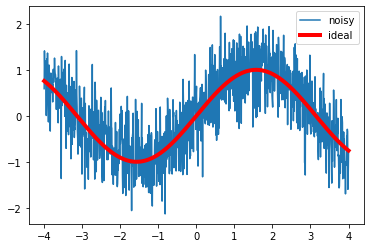

In [5]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [6]:
kernel = np.array([0.2,0.2,0.2,0.2,0.2])
denoised_signal = convolve(noisy_signal, kernel, 'same')

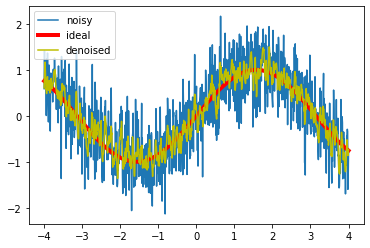

In [7]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

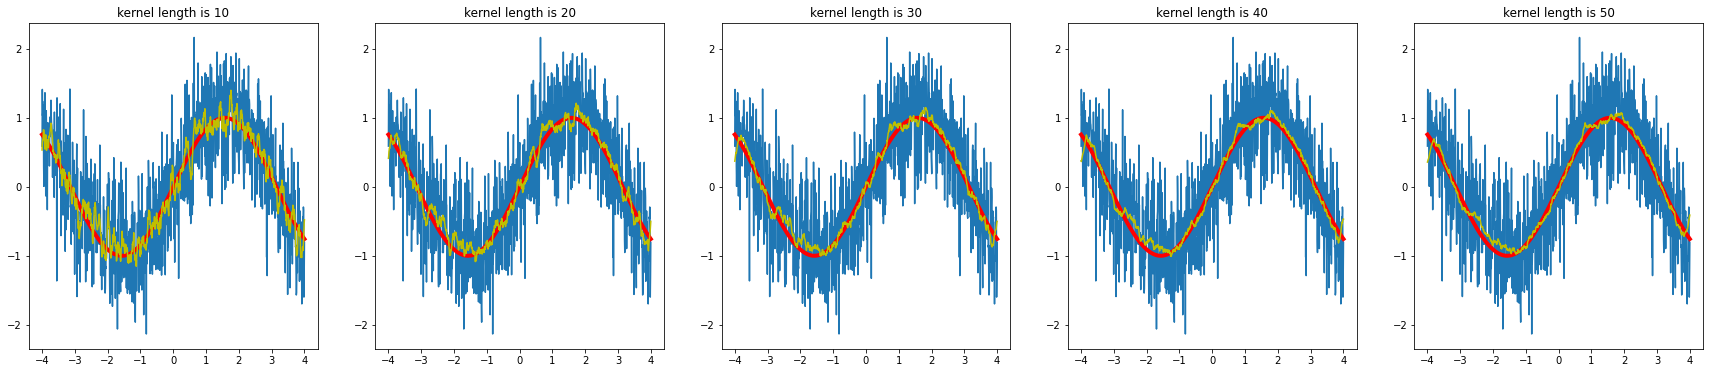

In [8]:
fig = plt.figure(figsize=(30, 6))
for length in [10, 20, 30, 40, 50]:
  kernel = np.ones(length) / length
  denoised_signal = convolve(noisy_signal, kernel, 'same')
  plt.subplot(1,5,length // 10)
  plt.plot(x, noisy_signal, label='noisy')
  plt.plot(x, signal, 'r', label='ideal', linewidth=4)
  plt.plot(x, denoised_signal, 'y', label='denoised')
  plt.title('kernel length is ' + str(length))

<i> 1.3 Подберите размер окна <i>

In [9]:
for size in range(3, 999, 2):
    kernel = np.ones(size)
    kernel /= kernel.shape[0]

    denoised_signal = convolve(noisy_signal, kernel, 'same')    
    error = ((signal - denoised_signal)**2).mean()
    
    print("ks = {}, error = {}".format(size, error))

ks = 3, error = 0.08604178048828304
ks = 5, error = 0.05172043042928398
ks = 7, error = 0.037575393231125506
ks = 9, error = 0.029118670052829487
ks = 11, error = 0.023735936401275207
ks = 13, error = 0.019941254360583444
ks = 15, error = 0.017019514508677967
ks = 17, error = 0.014804043437475201
ks = 19, error = 0.013167061645437784
ks = 21, error = 0.011919735746397072
ks = 23, error = 0.011050750518186617
ks = 25, error = 0.010331596410259198
ks = 27, error = 0.009744880846326376
ks = 29, error = 0.009251081746505914
ks = 31, error = 0.008792768576583735
ks = 33, error = 0.008432025314991605
ks = 35, error = 0.008078101120977604
ks = 37, error = 0.007781268244836937
ks = 39, error = 0.007569287570405623
ks = 41, error = 0.007396453808779712
ks = 43, error = 0.007242147314759149
ks = 45, error = 0.007112829961391329
ks = 47, error = 0.007015892930114845
ks = 49, error = 0.006920930039299299
ks = 51, error = 0.006835437102021746
ks = 53, error = 0.006755777432970691
ks = 55, error = 0

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [10]:
image = plt.imread('./sample_data/cup.jpg')

In [11]:
image.shape

(400, 600, 3)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [12]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

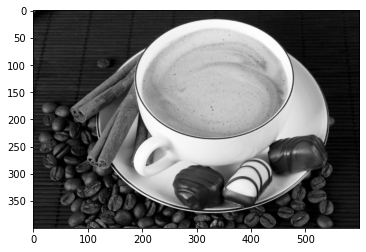

In [13]:
bw_image = convolve(image.flatten(), color_to_bw, 'same')[1::3].reshape(*image.shape[:2])
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [14]:
from scipy.signal import convolve2d

cobel_kernel = np.array([[-1, -2, -1],
                         [0, 0, 0],
                         [1, 2, 1]])

res_y = convolve2d(bw_image, cobel_kernel.T, 'same')
res_x = convolve2d(bw_image, cobel_kernel, 'same')

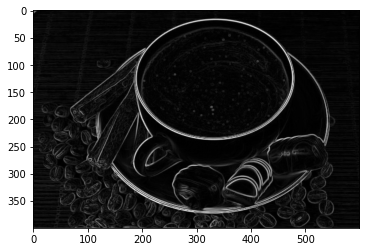

In [15]:
plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [16]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    
    res_img = np.zeros(signal.shape[:2] + (kernel.shape[0],))

    for i in range(res_img.shape[-1]):
      res_img[:, :, i] = convolve(signal, kernel[i, :, :, :], 'valid')[:, :, 0]
    
    return res_img

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [17]:
bgr_kernel = np.array([[[[1,0,0]]],
                       [[[0,1,0]]],
                       [[[0,0,1]]]])

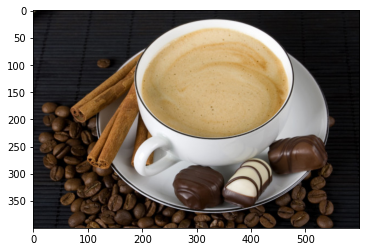

In [18]:
plt.imshow(image)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

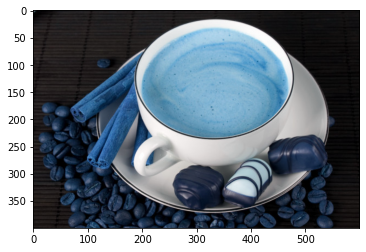

In [19]:
res_image = t_convolve_bank(image, bgr_kernel)
plt.imshow(res_image.astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [20]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.max(image[i:i+w, j:j+w, k])
                
    return res
    

def medianpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.median(image[i:i+w, j:j+w, k])
                
    return res
  
def meanpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, image.shape[0], w):
        for j in range(0, image.shape[1], w):
            for k in range(image.shape[2]):
                res[i//w, j//w, k] = np.mean(image[i:i+w, j:j+w, k])
                
    return res

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

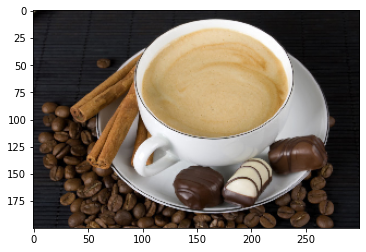

In [21]:
pooled = maxpool(image)
plt.imshow(pooled.astype('uint8'))

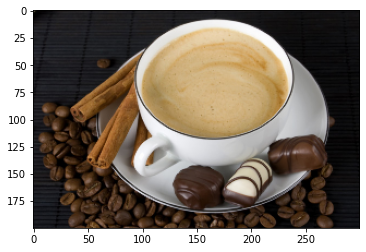

In [22]:
pooled = medianpool(image)
plt.imshow(pooled.astype('uint8'))

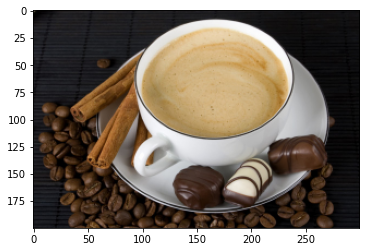

In [23]:
pooled = meanpool(image)
plt.imshow(pooled.astype('uint8'))

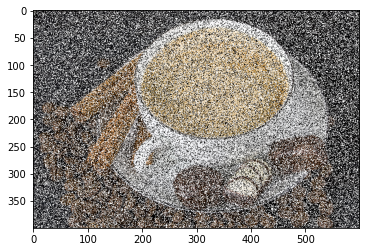

In [24]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

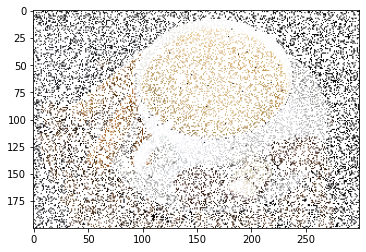

In [25]:
plt.imshow(maxpool(res_image).astype('uint8'))

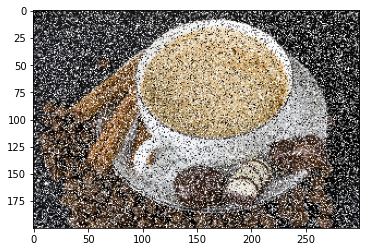

In [26]:
plt.imshow(medianpool(res_image).astype('uint8'))

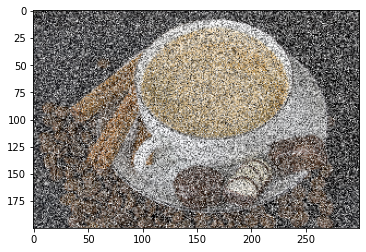

In [27]:
plt.imshow(meanpool(res_image).astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [28]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [37]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(8, 16, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [30]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.086/0.076	Accuracy: 0.975/0.976


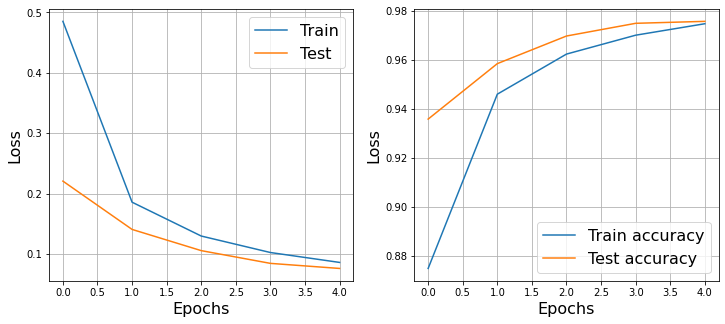

In [38]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

In [41]:
class ConvClassifier2(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), nn.ReLU(), nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

Epoch 4... (Train/Test) NLL: 0.065/0.058	Accuracy: 0.981/0.980


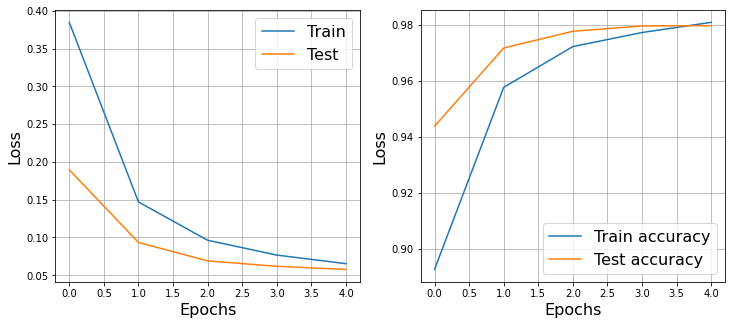

In [42]:
network = ConvClassifier2(image_size=28)
train(network, 5, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [48]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    prediction = network.forward(X)
    prediction = np.exp(prediction.detach().numpy())
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

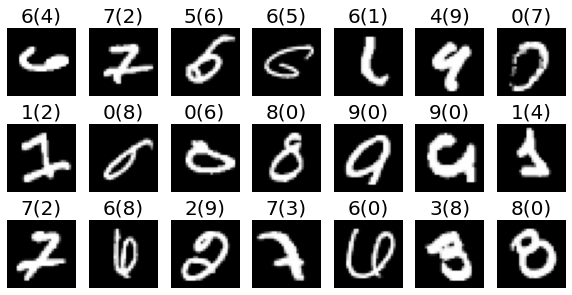

In [49]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [ ]:
##### YOUR CODE HERE #####

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: